In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from tqdm import tqdm
import os, gc, random, sys, warnings
from skimage.io import imread, imshow
from skimage.morphology import closing, opening, disk, label
from skimage.transform import resize
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dropout,Conv2DTranspose, concatenate, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy


seed = 42
random.seed = seed
np.random.seed = seed

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input','data-science-bowl-2018')
IMG_CHANNELS = 3
IMG_WIDTH = 512
IMG_HEIGHT = 512

Using TensorFlow backend.


In [2]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2,y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)  


def clean_img(x):
    return opening(closing(np.squeeze(x), disk(1)), disk(3))

def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

def load_path(df,train):
    '''
    return df : Change ['images'] and ['masks'] to include every path to load data
    Train = False to ignore ['masks'] column
    '''
    rows = []
    group_cols = ['Stage', 'ImageId']
    if train :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    else :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    return pd.DataFrame(rows)  
        

def out_pred_df(test_df,str_):
    print("Loading batch : "+str(str_)+" --> ",end='')
    test_img_df = load_path(test_df,train=False)
    test_size = test_img_df.shape[0]
    X_test = np.zeros((test_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    sys.stdout.flush()
    for n, row in test_img_df.iterrows():
        img = imread(row['images'][0])
        sizes_test.append([img.shape[0], img.shape[1]])
        if len(img.shape)==2:
            img_correct = np.expand_dims(img/255., axis=2)
            img_RG = np.append(img_correct,img_correct,2)
            img_RGB = np.append(img_RG,img_correct,2)
            img = img_RGB
        img = img[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
    sys.stdout.flush()
    preds_test = np.average([model[i].predict(X_test, verbose=0) for i in range(0,kf)],axis=0)
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(clean_img(preds_test[i])), 
                                           (sizes_test[i][0], sizes_test[i][1]), 
                                           mode='constant', preserve_range=True))
    test_img_df['rles'] = pd.Series(preds_test_upsampled).map(lambda x : list(prob_to_rles(x)))
    out_pred_list = []
    for _, c_row in test_img_df.iterrows():
        for c_rle in c_row['rles']:
            out_pred_list+=[dict(EncodedPixels = ' '.join(np.array(c_rle).astype(str)),ImageId=c_row['ImageId'])]
    out_pred_df = pd.DataFrame(out_pred_list)
    print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
    gc.collect()
    return out_pred_df[['ImageId', 'EncodedPixels']]

## Référencement données totales (Stage1[train/test] | Stage2[test])

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage*', '*', '*', '*'))
all_images.remove('../input/data-science-bowl-2018/stage2_test_final/170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece/images/170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece.png')
img_df = pd.DataFrame({'path': all_images})
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('/')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('/')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[0])
img_df.describe()

path   ...     Stage
count                                               33214   ...     33214
unique                                              33214   ...         2
top     ../input/data-science-bowl-2018/stage1_train/2...   ...    stage1
freq                                                    1   ...     30196

[4 rows x 5 columns]

## Chargement des données d'entraînement

In [4]:
train_df = img_df.query('TrainingSplit=="train"')
train_img_df = load_path(train_df,train = True)
train_img_df.head()

ImageId                        ...                                                                      masks
0  00071198d059ba7f5914a526d124d28e6d010c92466da2...                        ...                          [../input/data-science-bowl-2018/stage1_train/...
1  003cee89357d9fe13516167fd67b609a164651b2193458...                        ...                          [../input/data-science-bowl-2018/stage1_train/...
2  00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...                        ...                          [../input/data-science-bowl-2018/stage1_train/...
3  0121d6759c5adb290c8e828fc882f37dfaf3663ec885c6...                        ...                          [../input/data-science-bowl-2018/stage1_train/...
4  01d44a26f6680c42ba94c9bc6339228579a95d0e2695b1...                        ...                          [../input/data-science-bowl-2018/stage1_train/...

[5 rows x 4 columns]

In [5]:
train_size = train_img_df.shape[0]
X_train = np.zeros((train_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Loading and resizing Stage1_train images and masks ... ')
sys.stdout.flush()
for n, row in tqdm(train_img_df.iterrows(), total=train_size):
    X_train[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask in row['masks']:
        mask_=np.expand_dims(resize(imread(mask), (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        masks = np.maximum(masks, mask_)
    Y_train[n] = masks
#stage1_test_df = img_df.query('Stage=="stage1"')
#stage1_test_df = stage1_test_df.query('TrainingSplit=="test"')
#stage_1_test_img_df = load_path(stage1_test_df,train = False)
#stage1_solution = pd.read_csv(os.path.join('..', 'input','stage1-test-solution','stage1_solution.csv'))
#rows=[]
#for i,row in stage1_solution.iterrows():
#    rows.append(rleToMask(row['EncodedPixels'],row['Height'],row['Width']))
#stage1_solution['masks']=pd.Series(rows)
#rows=[]
#for n_group, n_rows in stage1_solution.groupby(["ImageId"]):
#    c_row = {"ImageId": n_group}
#    c_row['masks'] = n_rows['masks'].values.tolist()
#    rows += [c_row]
#merge = pd.merge(stage_1_test_img_df, pd.DataFrame(rows), on='ImageId')
#solution_size = merge.shape[0]
#X_train_solution = np.zeros((solution_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#Y_train_solution = np.zeros((solution_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#print('Loading and resizing Stage1_test_solutions images and masks ... ')
#sys.stdout.flush()
#for n, row in tqdm(merge.iterrows(), total=solution_size):
#    X_train_solution[n] = resize(imread(row['images'][0])[:,:,:IMG_CHANNELS], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#    masks = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#    for mask in row['masks']:
#        mask_ = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
#        masks = np.maximum(masks, mask_)
#    Y_train_solution[n] = masks
#X_train = np.concatenate((X_train,X_train_solution),axis=0)
#Y_train = np.concatenate((Y_train,Y_train_solution),axis=0)
#train_size = X_train.shape[0]
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

Loading and resizing Stage1_train images and masks ... 


100%|██████████| 670/670 [07:05<00:00,  3.50it/s]


## Visualisation des données d'entraînement

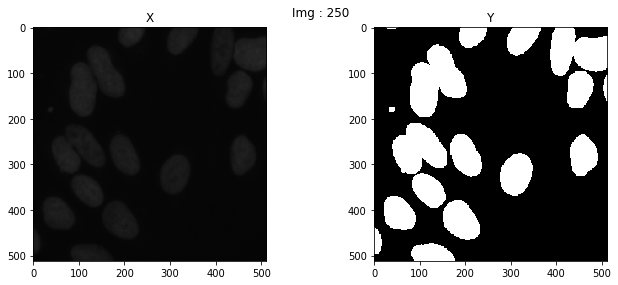

In [6]:
ix = random.randint(0, train_size)
fig = plt.figure(figsize=(12,4))
fig.suptitle("Img : "+str(ix))
fig.add_subplot(1,2,1).set_title("X", fontsize='large')
imshow(X_train[ix])
fig.add_subplot(1,2,2).set_title("Y", fontsize='large')
imshow(np.squeeze(np.squeeze(Y_train[ix])))
plt.show()

## Construction CNN

In [7]:
def Unet():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    return Model(inputs=[inputs], outputs=[outputs])

### Training

In [8]:
kf = 6
epochs = 50
batch_size = 16
model = [0]*kf
earlystopper = [0]*kf
h = [0]*kf
for i in range(kf):
    d = int(i*train_size/kf)
    f = int((i+1)*train_size/kf)
    X_train_batch_t,X_train_batch_v = np.concatenate((X_train[:d],X_train[f:]),axis=0), X_train[d:f]
    Y_train_batch_t,Y_train_batch_v = np.concatenate((Y_train[:d],Y_train[f:]),axis=0), Y_train[d:f]
    model[i] = Unet()
    model[i].compile(optimizer = 'adam',loss = bce_dice_loss, metrics = [mean_iou])
    earlystopper[i] = EarlyStopping(patience=10, verbose=1)
    h[i] = model[i].fit(X_train_batch_t,Y_train_batch_t, validation_data = (X_train_batch_v,Y_train_batch_v),batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper[i]],verbose = 0)
    print("CNN {0:d}: Epochs = {1:d}, Train mean_iou = {2:.5f}, Validation mean_iou = {3:.5f}".format(
        i+1,epochs,max(h[i].history['mean_iou']),max(h[i].history['val_mean_iou']) ))
    model[i].save('model_'+str(i)+'.h5')
    model[i] = None
    gc.collect();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 00041: early stopping
CNN 1: Epochs = 50, Train mean_iou = 0.43235, Validation mean_iou = 0.43253
CNN 2: Epochs = 50, Train mean_iou = 0.43809, Validation mean_iou = 0.43822
Epoch 00045: early stopping
CNN 3: Epochs = 50, Train mean_iou = 0.43932, Validation mean_iou = 0.43948
Epoch 00043: early stopping
CNN 4: Epochs = 50, Train mean_iou = 0.43933, Validation mean_iou = 0.43949
Epoch 00046: early stopping
CNN 5: Epochs = 50, Train mean_iou = 0.44032, Validation mean_iou = 0.44046
Epoch 00043: early stopping
CNN 6: Epochs = 50, Train mean_iou = 0.44077, Validation mean_iou = 0.4

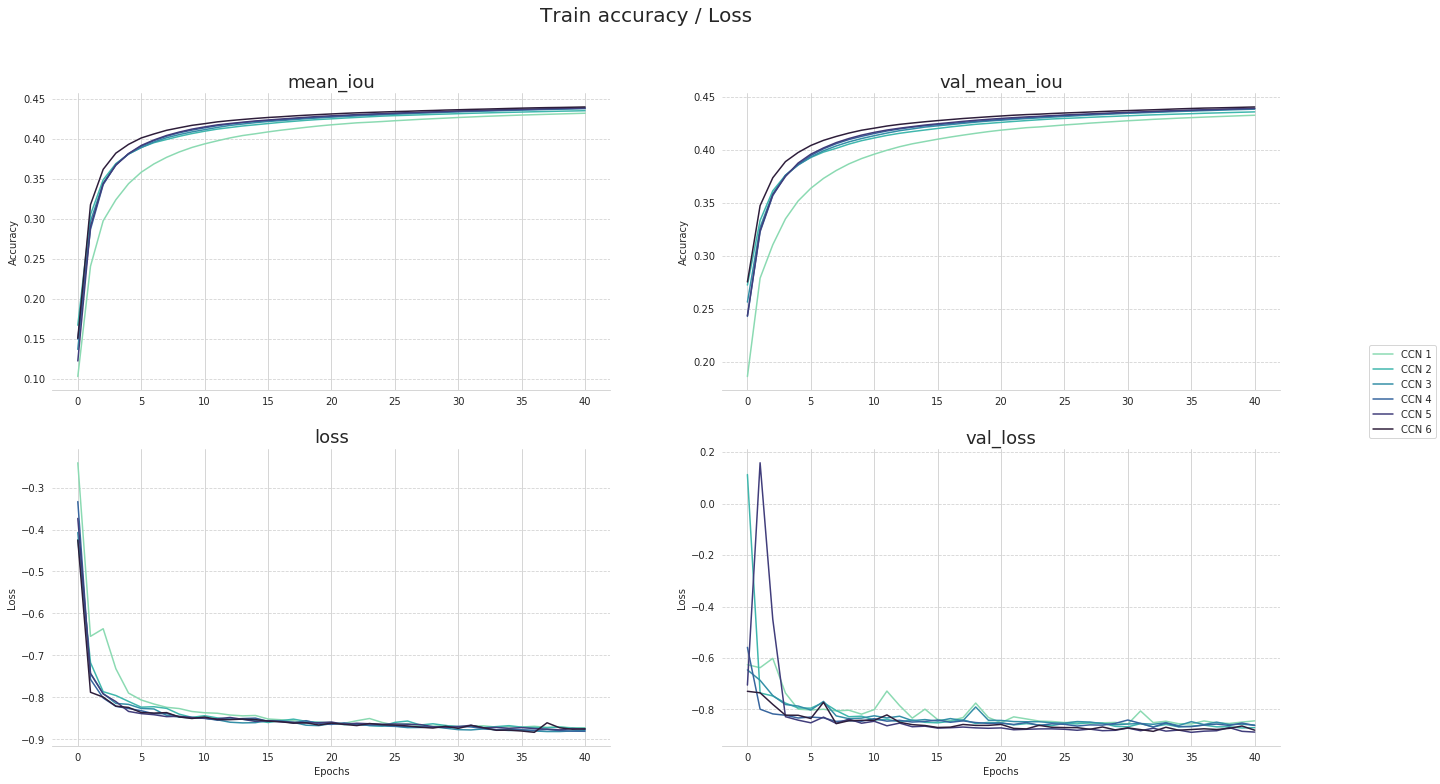

In [9]:
min_epochs = min([len(h[i].history['val_loss']) for i in range(kf)])
sns.set_style("whitegrid")
palette = sns.color_palette("mako_r", 6)
fig, ax = plt.subplots(2, 2,figsize=(22,12))
fig.suptitle("Train accuracy / Loss",fontsize=20)
sns.despine(left=True)
for row,row_n in zip([['mean_iou','val_mean_iou'],['loss','val_loss']],range(2)):
    for col in range(2):
        colors=0
        for w in range(kf):
            sns.lineplot(range(min_epochs),h[w].history[row[col]][:min_epochs],ax=ax[row_n, col],color=palette[colors])
            colors=colors+1
            ax[row_n, col].grid(True,which="both",axis="y",ls="--",c='lightgray')  
            ax[row_n, col].set_title(row[col],fontsize=18)
for a,f in zip(ax.flat,range(4)):
    a.set(ylabel='Accuracy') if f<2 else a.set(xlabel='Epochs', ylabel='Loss')
fig.legend(["CCN "+str(i) for i in range(1,7)],loc=7)
sns.set_style("white")

In [10]:
model = [0]*kf
for j in range(kf):
    pd.DataFrame(h[j].history).to_csv('CNN_'+str(j)+'.csv', index = True)
    model[j] = load_model('model_'+str(j)+'.h5', custom_objects={'mean_iou': mean_iou,'bce_dice_loss' : bce_dice_loss})

## Prédictions

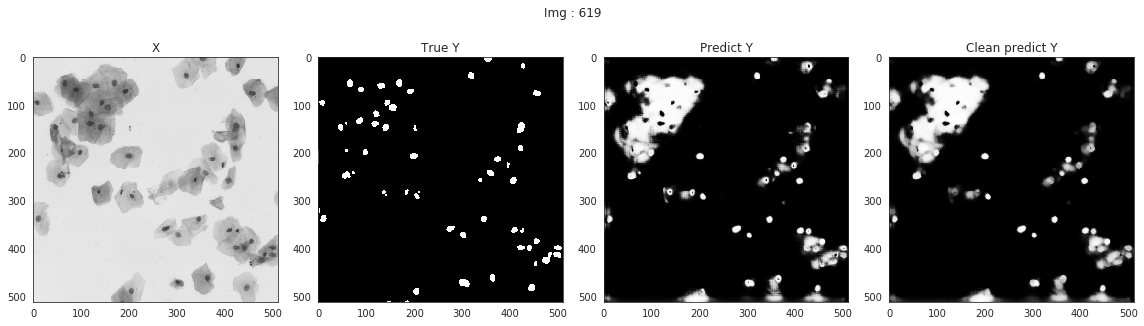

In [11]:
ix = random.randint(0, X_train.shape[0]-1)
fig = plt.figure(figsize=(16,5))
fig.suptitle("Img : "+str(ix))
fig.add_subplot(1,4,1).set_title("X", fontsize='large')
imshow(X_train[ix])
fig.add_subplot(1,4,2).set_title("True Y", fontsize='large')
imshow(np.squeeze(Y_train[ix]))
fig.add_subplot(1,4,3).set_title("Predict Y", fontsize='large')
imshow(np.squeeze(model[0].predict(np.expand_dims(X_train[ix],0))))
fig.add_subplot(1,4,4).set_title("Clean predict Y", fontsize='large')
imshow(clean_img(np.squeeze(model[0].predict(np.expand_dims(X_train[ix],0)))))
plt.show()

In [12]:
test_df_tot = img_df.query('TrainingSplit=="test"')
test_df_stage_2 = test_df_tot.query('Stage=="stage2"')
gc.collect();

In [13]:
fract = 20
l = test_df_stage_2.shape[0]
default = pd.DataFrame([dict(ImageId='170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece',
                   EncodedPixels = '1 1')])

pd.concat([out_pred_df(i,j) for i,j in zip([test_df_stage_2[int(l/fract*i):int(l/fract*(i+1))] for i in range(fract)]
                                       ,np.arange(0,fract))]+[default]).reindex(columns = ['ImageId','EncodedPixels']).to_csv('predictions.csv', index = False)

Loading batch : 0 --> 3561 regions found for 150 images
Loading batch : 1 --> 4159 regions found for 151 images
Loading batch : 2 --> 3481 regions found for 151 images
Loading batch : 3 --> 3183 regions found for 151 images
Loading batch : 4 --> 3436 regions found for 151 images
Loading batch : 5 --> 3975 regions found for 151 images
Loading batch : 6 --> 3603 regions found for 151 images
Loading batch : 7 --> 3392 regions found for 151 images
Loading batch : 8 --> 3530 regions found for 151 images
Loading batch : 9 --> 4046 regions found for 151 images
Loading batch : 10 --> 4017 regions found for 150 images
Loading batch : 11 --> 3851 regions found for 151 images
Loading batch : 12 --> 3758 regions found for 151 images
Loading batch : 13 --> 3133 regions found for 151 images
Loading batch : 14 --> 3566 regions found for 151 images
Loading batch : 15 --> 3840 regions found for 151 images
Loading batch : 16 --> 4857 regions found for 151 images
Loading batch : 17 --> 3472 regions found

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys
